# 0.0 - Imports

In [1]:
# Bibliotecas
import pandas     as pd
import numpy      as np
import inflection
import seaborn    as sns
import umap.umap_ as umap

from IPython.display     import HTML

from matplotlib          import pyplot as plt

from plotly              import express

from sklearn             import cluster
from sklearn             import metrics
from sklearn             import preprocessing

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 - Helper Functions

In [2]:
snakecase = lambda x: inflection.underscore(x)

# Configurações de Layout
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (24,9)
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:90% ! important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 - Carregamento dos dados

In [3]:
# Carregar os dados para análise.
df = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'unicode_escape').drop(columns=['Unnamed: 8'])

# 1.0 - Descrição dos Dados

In [4]:
df1 = df.copy()

## 1.1 - Atributos

**InvoiceNo:** Número que identifica a transação da compra.

**StockCode:** Código do produto.

**Description:** Descrição do produto.

**Quantify:** Quantidade comprada do produto.

**InvoiceDate:** Data em que a transação foi efetuada.

**UnitPrice:** Preço unitário do produto comprado.

**CustomerID:** Número que identifica o cliente.

**Country:** País em que o cliente realizou a transação.

## 1.2 - Dimensão dos Dados

In [5]:
rows = df1.shape[0]
columns = df1.shape[1]

print(f'Número de Linhas: {rows}.')
print(f'Número de Colunas: {columns}')

Número de Linhas: 541909.
Número de Colunas: 8


## 1.3 - Renomear Nome das Colunas

In [6]:
# Renomear Lista
lista = df1.columns.tolist()

# Nome das novas colunas
new_columns = [snakecase(x) for x in lista]

# renomear as colunas
df1.columns = new_columns

## 1.4 - Check NA

In [7]:
# Verificação e existem dados nulos
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [8]:
# Dropagem das linhas que possuem NA
df1 = df1.dropna()

# Verificação
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 - Natureza das Variáveis

In [9]:
# Verificando a tipagem dos dados.
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.6 - Limpeza dos Dados

In [10]:
# Nome dos produtos em tamanho minúsculo.
df1['description'] = df1['description'].apply(lambda x: x.lower())

# Nome dos paíse em tamanho minúsculo.
df1['country'] = df1['country'].apply(lambda x: x.lower())

## 1.7 - Mudança de Variáveis

In [11]:
# Mudança de tipagem do invoice_date
df1['invoice_date'] = df1['invoice_date'].apply(lambda x: pd.to_datetime(x))

# customer_id
df1['customer_id'] = df1['customer_id'].apply(lambda x: str(int(x)))

## 1.8 - Estatística Descritiva 

### 1.8.1 - Atributos Numéricos

In [12]:
# Separando somente os dados numéricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# ------------ Tendências Centrais ---------------------------------

# Média
mean = pd.DataFrame(num_attributes.apply(np.mean)).T

# Mediana
median = pd.DataFrame(num_attributes.apply(np.median)).T

# ---------- Tendências de Dispersão -------------------------------

# Máximo
maximo = pd.DataFrame(num_attributes.apply(np.max)).T

# Mínimo
minimo = pd.DataFrame(num_attributes.apply(np.min)).T

# Intervalo(Range)
intervalo = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# Desvio Padrão
desvio = pd.DataFrame(num_attributes.apply(np.std)).T

# Skewness
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

# Kurtosis
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# ---------------------- Construção da Tabela de Estatística Descritiva -------------------------------

# Concatenação das Tabela
tabela_descritiva = pd.concat([minimo, maximo, intervalo, mean, median, desvio, skew, kurtosis]).T.reset_index()
tabela_descritiva.columns = ['atributos', 'minimo', 'maximo', 'intervalo', 'media', 
                             'mediana', 'desvio_padrao', 'skewness', 'kurtosis']

# Exibição da tabela descritiva
tabela_descritiva

,atributos,minimo,maximo,intervalo,media,mediana,desvio_padrao,skewness,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988


### Investigação dos Atributos Numéricos

**1.** Quantidade de produtos negativo: Devolução ou Pedido Cancelado?

**2.** Preço unitário igual a zero: Promoção ou Brinde?

### 1.8.2 - Atributos Categóricos

In [13]:
#Separação das Variáveis Categóricas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'customer_id', 'country'], dtype='object')

#### Invoice No

In [14]:
# Exploração da variável invoice_no 
df_invoice =  df1.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))]

# ------- Verificação de quantidades negativas de invoice no com letras

# quantidade de dados do df_invoice
print('Quantidade de dados com Invoice_No com a letra C no início: {}'.format(len(df_invoice)))

# Quantidade de quantity negativos no df_invoice
print('Quantidade de dados com o quantity negativo: {}.'.format(len(df_invoice[df_invoice['quantity'] < 0])))

# exibição dos dados
df_invoice.head()

Quantidade de dados com Invoice_No com a letra C no início: 8905
Quantidade de dados com o quantity negativo: 8905.


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,discount,-1,2016-11-29,27.50,14527,united kingdom
154,C536383,35004C,set of 3 coloured flying ducks,-1,2016-11-29,4.65,15311,united kingdom
235,C536391,22556,plasters in tin circus parade,-12,2016-11-29,1.65,17548,united kingdom
236,C536391,21984,pack of 12 pink paisley tissues,-24,2016-11-29,0.29,17548,united kingdom
237,C536391,21983,pack of 12 blue paisley tissues,-24,2016-11-29,0.29,17548,united kingdom


#### StockCode

In [15]:
# Exploração da variável stock_code
df_stock_code =  df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x)))]

# Exibição
print(df_stock_code['stock_code'].unique().tolist())
df_stock_code.head()

['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,postage,3,2016-11-29,18.00,12583,france
141,C536379,D,discount,-1,2016-11-29,27.50,14527,united kingdom
386,536403,POST,postage,1,2016-11-29,15.00,12791,netherlands
1123,536527,POST,postage,1,2016-11-29,18.00,12662,germany
2239,536569,M,manual,1,2016-11-29,1.25,16274,united kingdom


- Os dados com stockCode somente como letra, em um primeiro momento, não nos traz informaçãoes de como impacta no faturamento.
- Remoção de dados da coluna stock_code.

#### Description

In [16]:
cat_attributes.head()

,invoice_no,stock_code,description,customer_id,country
0,536365,85123A,white hanging heart t-light holder,17850,united kingdom
1,536365,71053,white metal lantern,17850,united kingdom
2,536365,84406B,cream cupid hearts coat hanger,17850,united kingdom
3,536365,84029G,knitted union flag hot water bottle,17850,united kingdom
4,536365,84029E,red woolly hottie white heart.,17850,united kingdom


- remoção da description, pois ela não interfere na clusterização.

#### Country

In [17]:
# Países
cat_attributes['country'].unique()

array(['united kingdom', 'france', 'australia', 'netherlands', 'germany',
       'norway', 'eire', 'switzerland', 'spain', 'poland', 'portugal',
       'italy', 'belgium', 'lithuania', 'japan', 'iceland',
       'channel islands', 'denmark', 'cyprus', 'sweden', 'austria',
       'israel', 'finland', 'greece', 'singapore', 'lebanon',
       'united arab emirates', 'saudi arabia', 'czech republic', 'canada',
       'unspecified', 'brazil', 'usa', 'european community', 'bahrain',
       'malta', 'rsa'], dtype=object)

In [18]:
# Quantidade de transações
cat_attributes[['customer_id', 'country']].groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head(10)

,country,customer_id
34,united kingdom,361878
14,germany,9495
13,france,8491
10,eire,7485
30,spain,2533
23,netherlands,2371
3,belgium,2069
32,switzerland,1877
26,portugal,1480
0,australia,1259


In [19]:
# Quantidade de clientes por país
cat_attributes[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head(10)

,country,customer_id
34,united kingdom,3950
14,germany,95
13,france,87
30,spain,31
3,belgium,25
32,switzerland,21
26,portugal,19
18,italy,15
12,finland,12
1,austria,11


### Investigação dos Atributos Categóricos

**1.** Na variável 'invoive_no' temos alguns dados com a letra C na frente. Seriam notas canceladas/devolução?  Essas notas devem ser dropadas do dataset junto com as notas de saída?

**2.** Na variável 'stock_code' temos variaveis que estão misturadas com números e variáveis que são somente letras: Devemos considerar esses dados ou eliminá-los?

# 2.0 - Filtragem dos Dados

In [20]:
df2 = df1.copy()

In [21]:
# --------------------- Filtragem Atributos Categóricos --------------------
# lista de códigos a serem removido
list_of_codes = df_stock_code['stock_code'].unique().tolist()

# Remoção de códigos do estoque
df2 = df2[~df2['stock_code'].isin(list_of_codes)].copy()

# Remoção da variável description
df2 = df2.drop('description', axis=1).copy()


# ------------------- Filtragem Atributos Numéricos ------------------------
# Filtragem unit_price
df2 = df2[df2['unit_price'] >=0.04].copy()

# Armazenando os dados que foram cancelados ou devolvidos
df_devolucao = df2[df2['quantity'] < 0].copy()

# Armazenando os dados que foram faturados
df_faturamento = df2[df2['quantity'] >= 0].copy()

# 3.0 - Feature Engineering

In [22]:
df3 = df2.copy()

## 3.1 - Criação das Features


In [23]:
# Aqui vamos usar somente os dados de faturamento.


# ----------------- Construção das Features -------------------------

# Dataframe Referência
df_ref = df_faturamento.drop(['invoice_no', 'stock_code', 'quantity', 
                   'invoice_date','unit_price', 'country'], axis=1).copy()

# Remover duplicidades 
df_ref = df_ref.drop_duplicates().reset_index(drop=True)


# ------ Construção da Feature Recency ---------

df_recency = df_faturamento[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy() 

# Merge do df_recency com o dataframe referência.
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# ------ Construção da Feature Frequencily -------

df_frequencily = df_faturamento[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_frequencily = df_frequencily.rename(columns={'invoice_no' : 'frequencily'})

# Merge do df_frequencily com o dataframe referência.
df_ref = pd.merge(df_ref, df_frequencily, on='customer_id', how='left')


# ------ Construção da Feature Monetary -------

df_faturamento['total_by_product'] = df_faturamento['quantity'] * df_faturamento['unit_price']

df_monetary = df_faturamento[['customer_id', 'total_by_product']].groupby('customer_id').sum().reset_index()
df_monetary = df_monetary.rename(columns = {'total_by_product' : 'gross_revenue'})

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# ---------- Construção da Feature Average Ticket ---------------------

df_avg_ticket = df_faturamento[['customer_id', 'total_by_product']].groupby('customer_id').mean().reset_index()
df_avg_ticket = df_avg_ticket.rename(columns={'total_by_product':'avg_ticket'})
df_avg_ticket['avg_ticket'] = df_avg_ticket['avg_ticket'].apply(lambda x: round(x, 2))

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [24]:
df3 = df_ref.copy()
df3.head()

,customer_id,recency_days,frequencily,gross_revenue,avg_ticket
0,17850,372,34,5391.21,18.15
1,13047,56,9,3232.59,18.90
2,12583,2,15,6705.38,28.90
3,13748,95,5,948.25,33.87
4,15100,333,3,876.00,292.00


# 4.0 - Análise Exploratória dos Dados

In [25]:
df4 = df3.copy()

df4.isna().sum()

customer_id      0
recency_days     0
frequencily      0
gross_revenue    0
avg_ticket       0
dtype: int64

# 5.0 - Preparação dos Dados

In [26]:
df5 = df4.copy()

In [27]:
# Instanciando a Classe que padroniza os dados
ss = preprocessing.StandardScaler()

# Padronização dos dados para input no modelo.
df5['recency_days']  = ss.fit_transform(df5[['recency_days']])
df5['frequencily']   = ss.fit_transform(df5[['frequencily']])
df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['avg_ticket']    = ss.fit_transform(df5[['avg_ticket']])

# 6.0 - Seleção das Features

In [28]:
df6 = df5.copy()

# 7.0 - Hiperparameter FineTunning

In [29]:
df7 = df6.copy()

In [30]:
# Ajuste dos Dados os modelos
df_treino = df7.drop(columns=['customer_id'])

# quantidade de cluster
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 - Within-Cluster Sum of Square (WSS)

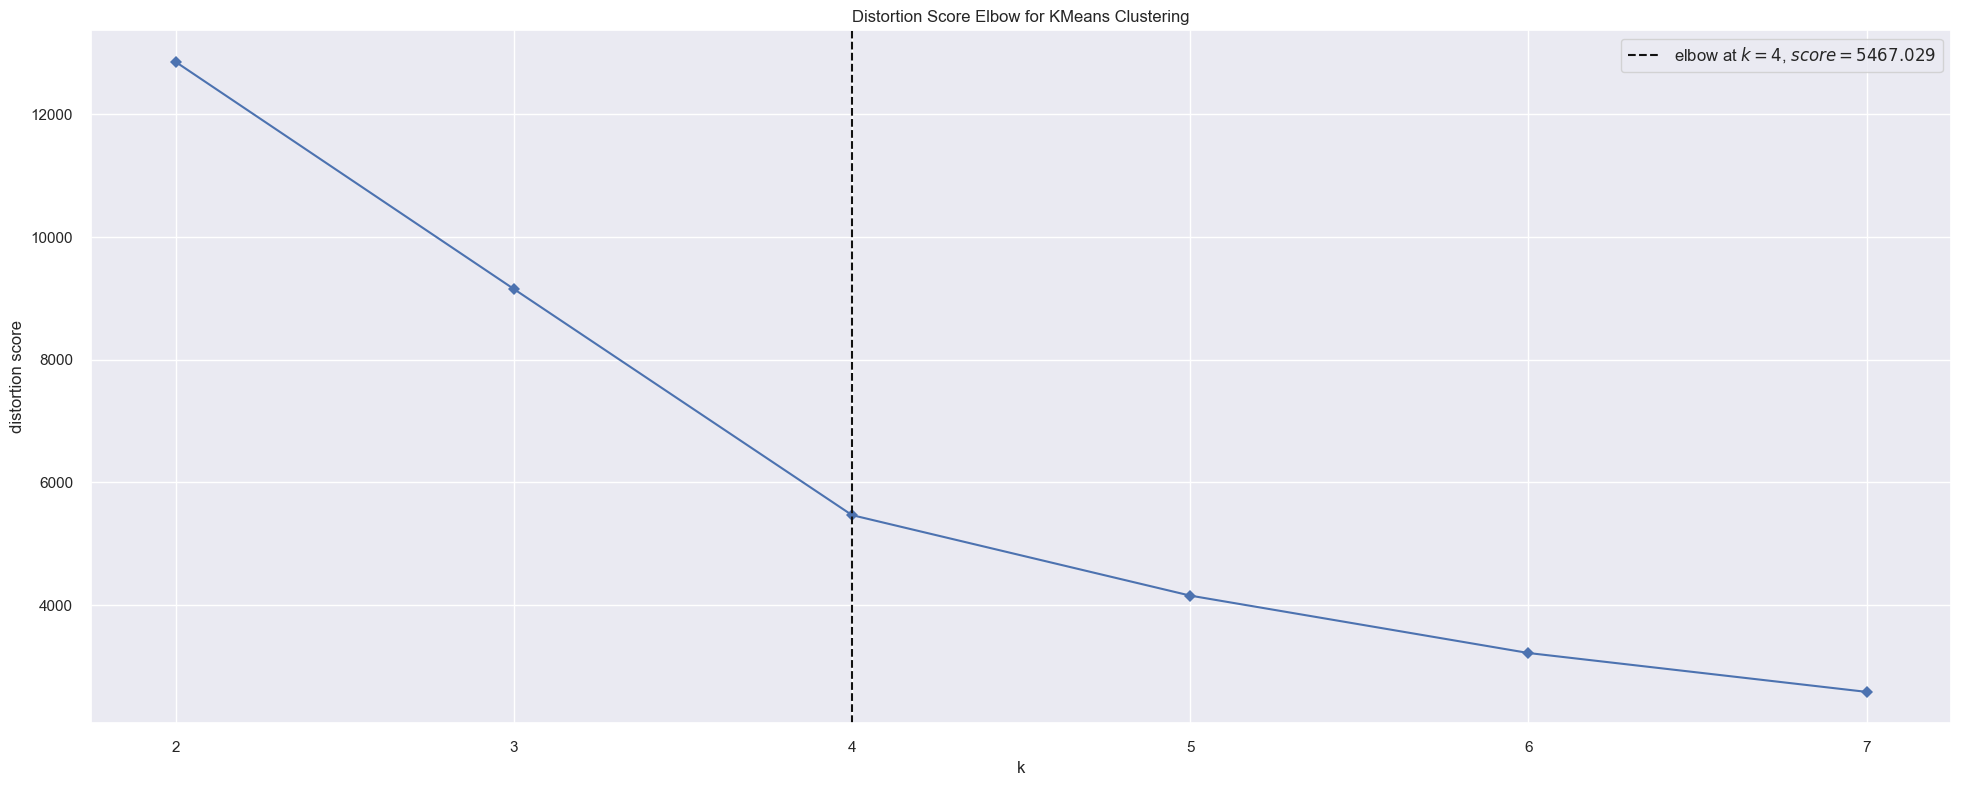

In [31]:
# model definition
#kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Usando o pacote yellowbrick para nos ajudar a determinar o melhor k de cluster.
graph_wss = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
graph_wss.fit(df_treino)
graph_wss.show();

In [83]:
df_treino.head()

,recency_days,frequencily,gross_revenue,avg_ticket
0,2.792291,3.891594,0.377555,-0.033916
1,-0.361628,0.621543,0.135617,-0.033405
2,-0.900589,1.406356,0.524847,-0.026595
3,0.027621,0.098335,-0.120412,-0.023211
4,2.403041,-0.163269,-0.128510,0.152575


## 7.2 Silhouette Score

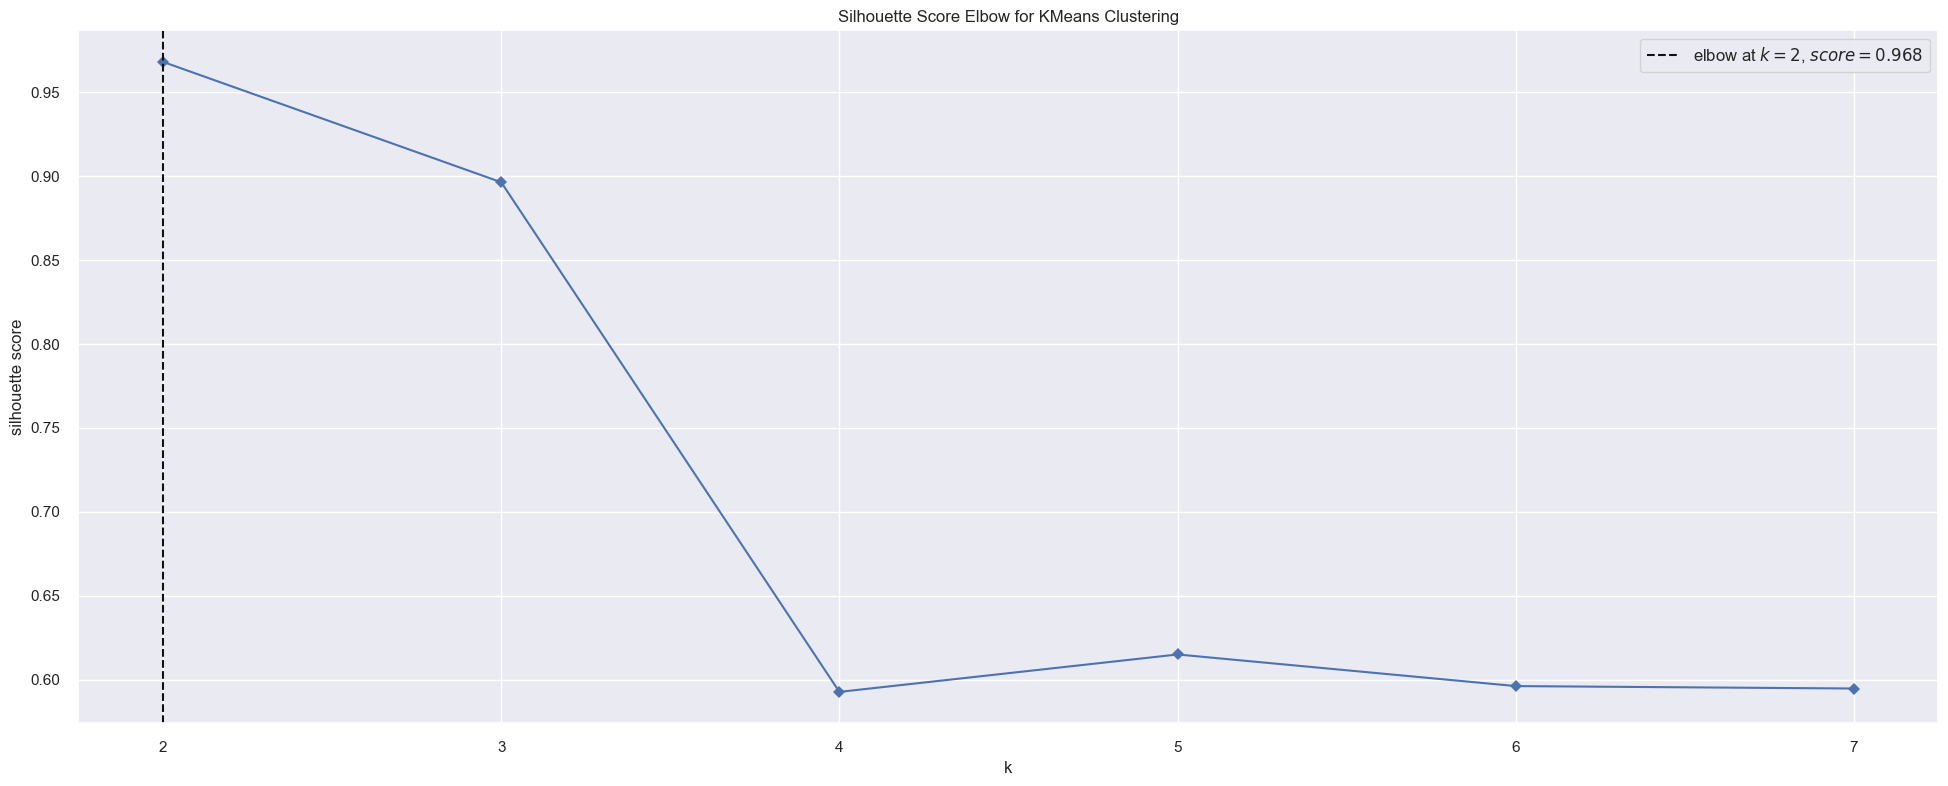

In [32]:
# Usando o pacote yellowbrick para nos ajudar a determinar o melhor k de cluster.
graph_silhoutte = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False)
graph_silhoutte.fit(df_treino)
graph_silhoutte.show();

## 7.3 - Analise da Silhouette

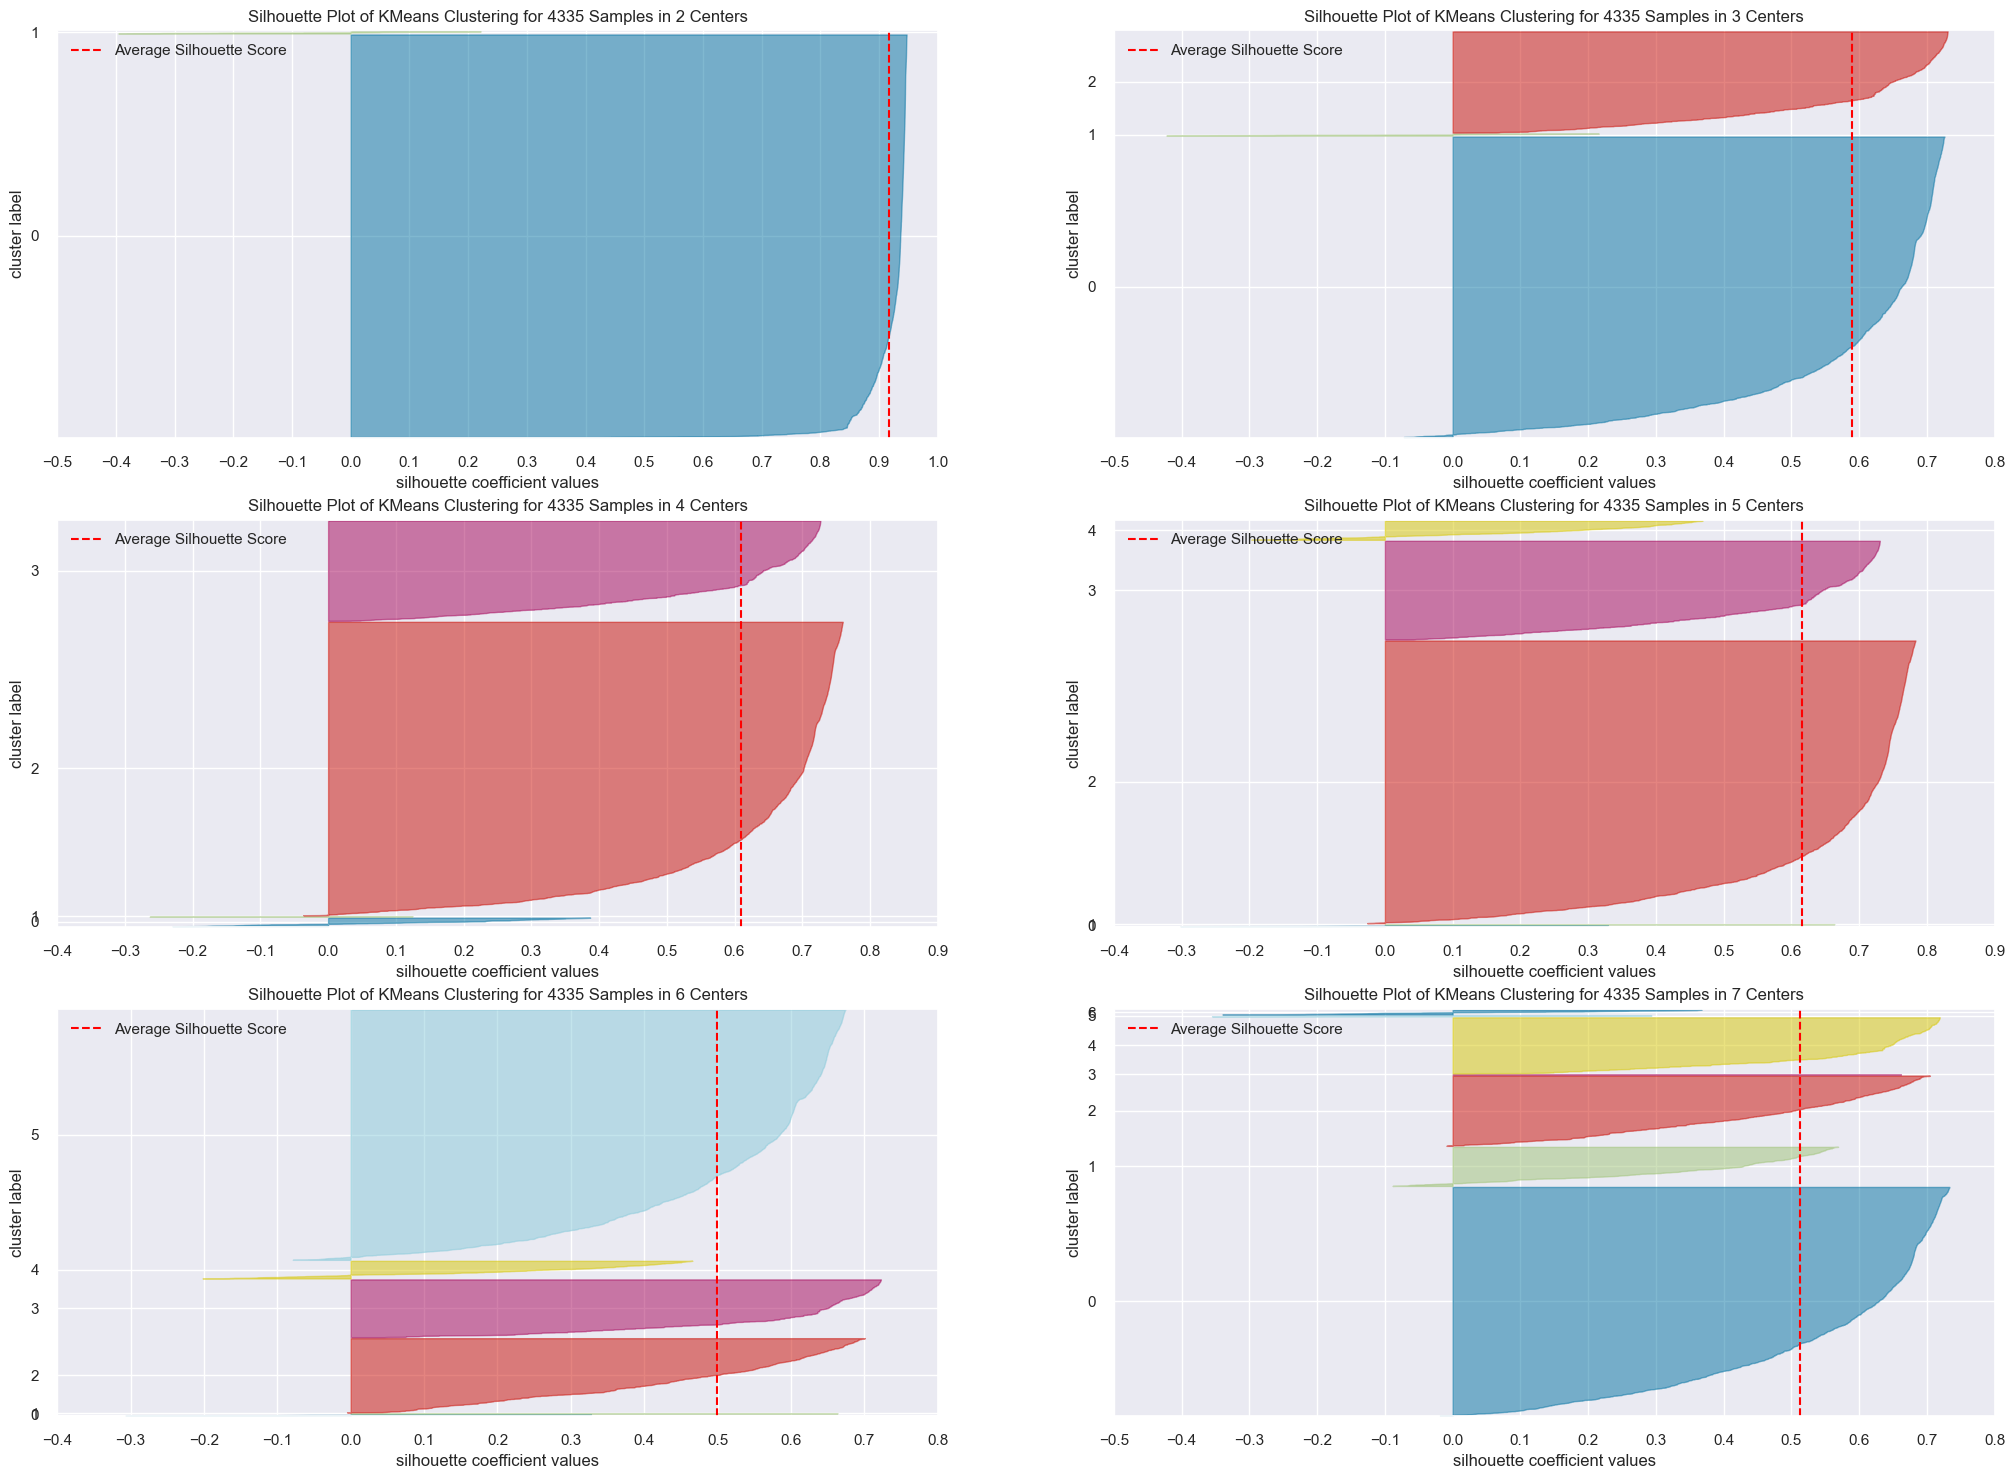

In [85]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    # Definição do modelo e seus parâmetros
    kmeans = cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
    
    # parâmetros para determinar as posições em que serão plotados os gráficos
    linha, coluna = divmod(k, 2)

    # Plotagem da Análise da Silhouette
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[linha -1][coluna])
    visualizer.fit(df_treino)
    visualizer.finalize()


# 8.0 - Model Training

## 8.1 - K-means

In [86]:
# Modelo definido
k=4
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treino do Modelo
kmeans.fit(df_treino)

# clustering
labels = kmeans.labels_

### 8.1.2 - K-means CrossValidation

In [87]:
# WSS Score
print(f'WSS Score: {kmeans.inertia_}.')

# Silhouette Score
print(f'Silhouette Score: {metrics.silhouette_score(df_treino, labels)}')

WSS Score: 7313.201351676122.
Silhouette Score: 0.6100652775940049


# 9.0 - Cluster Analysis

In [88]:
df9 = df_treino.copy()

# Rotulando cada cliente de acordo o o seu cluster
df9['cluster'] = labels

## 9.1 - Inspeção por Visualização - Analysis Silhouette

c:\users\xcell\repositorio\projects\project_clustering_customers\.clustering\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


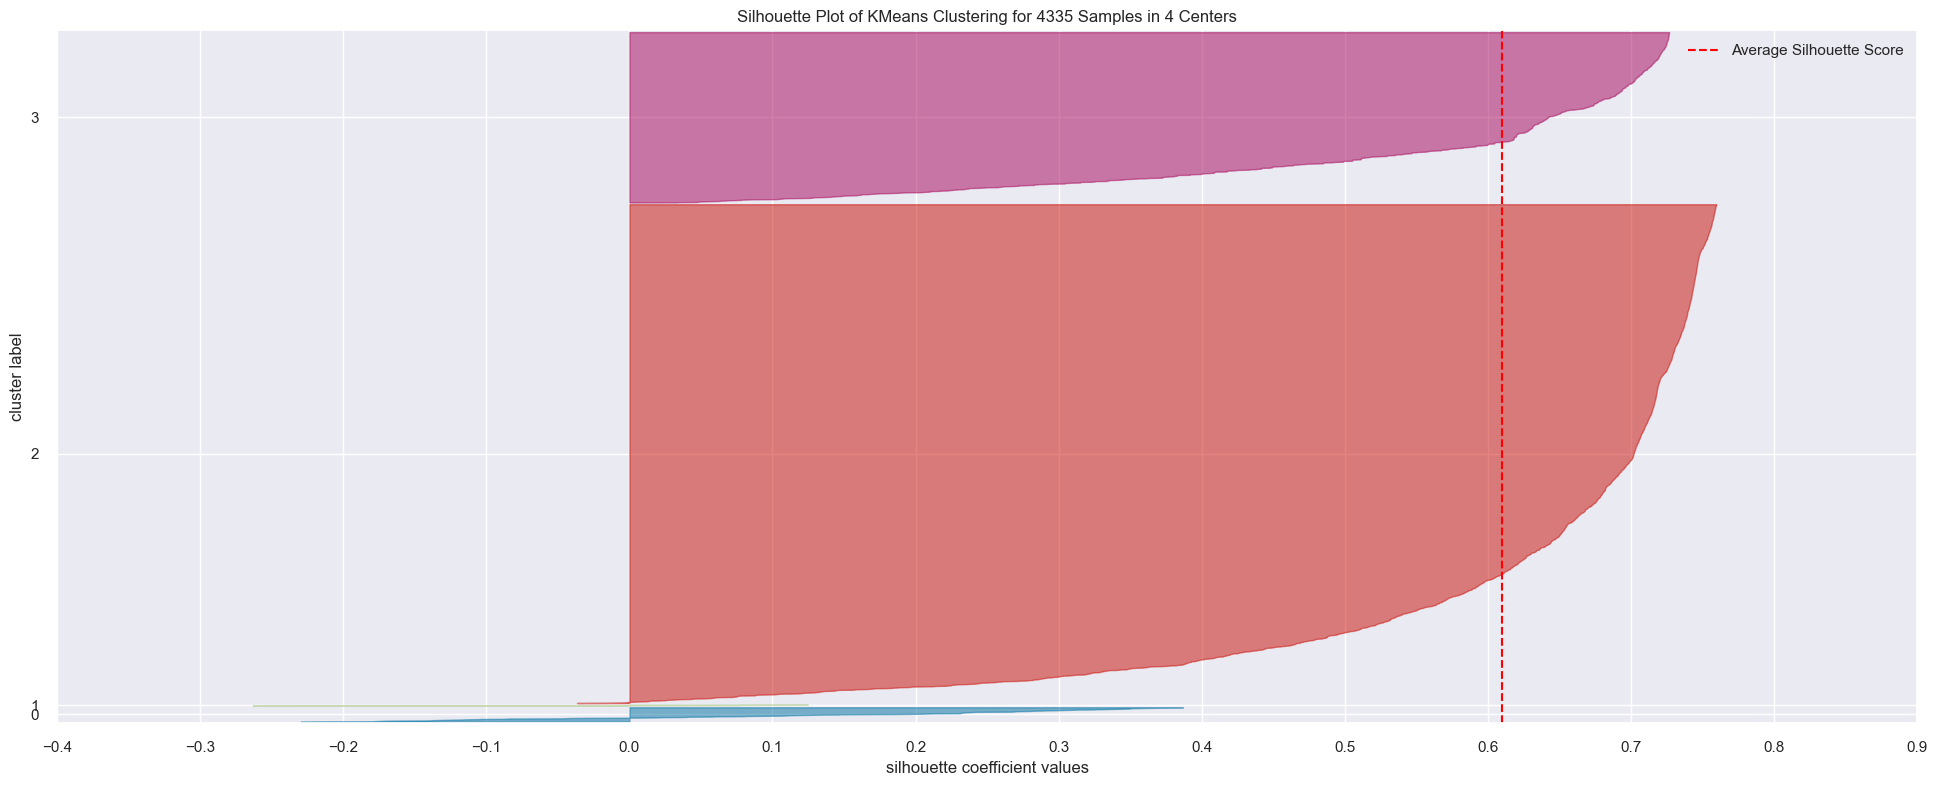

In [89]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_treino)
visualizer.finalize()

## 9.2 - Inspeção por Visualização - 2D Plot

In [94]:
df_analysis = df9.copy()
#sns.pairplot(df_analysis, hue='cluster', palette='crest');

## 9.3 - UMAP

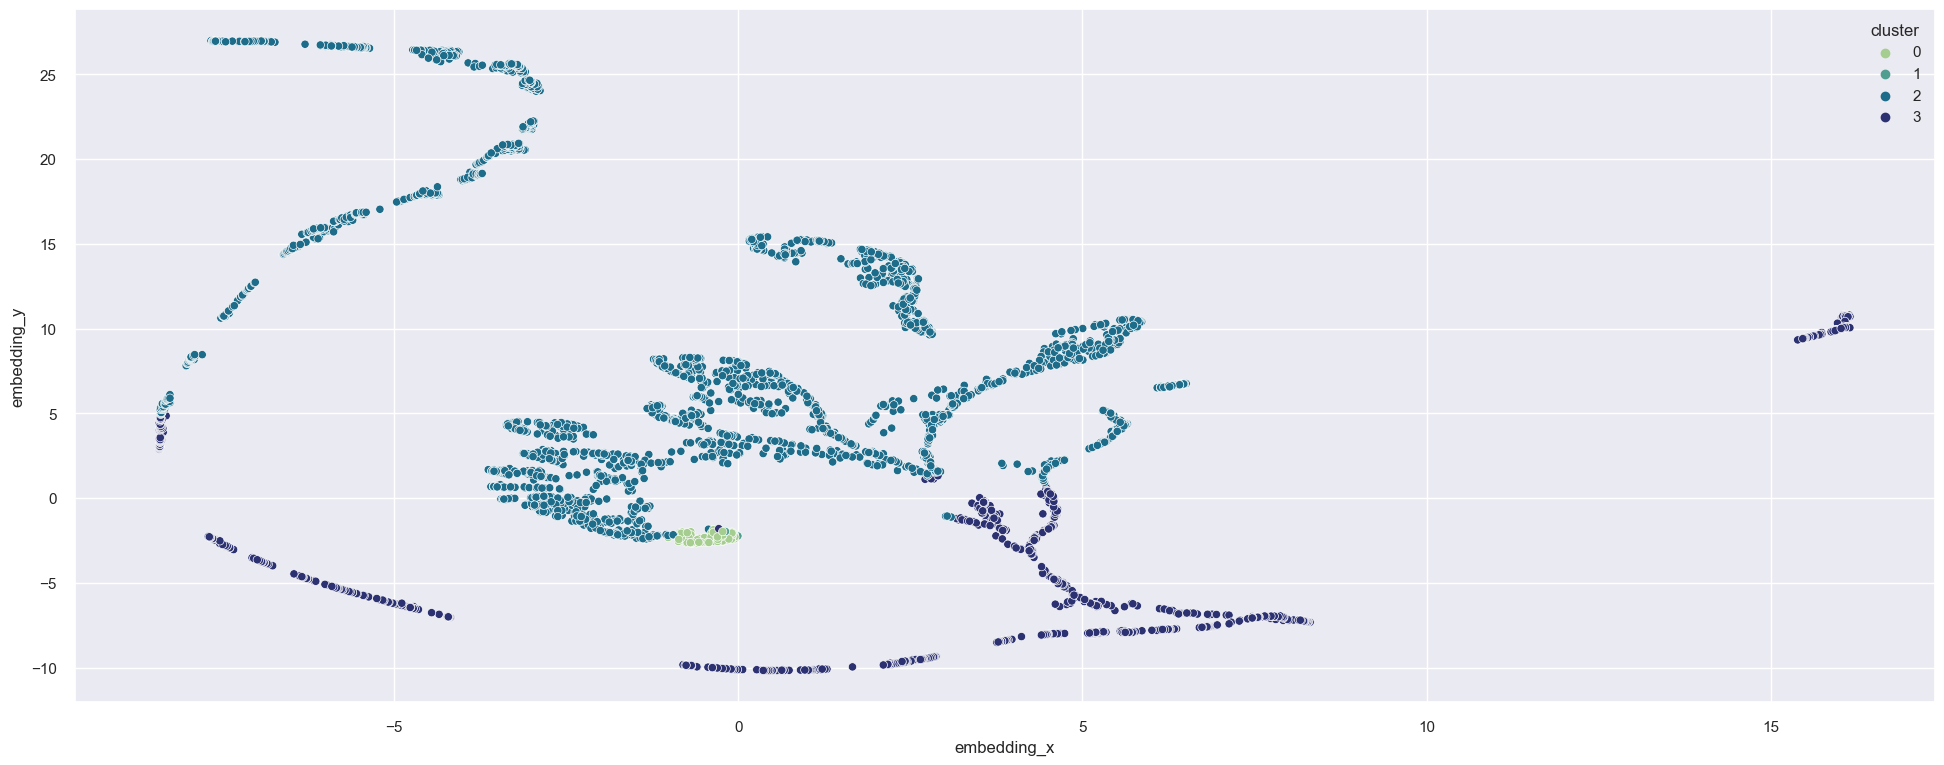

In [93]:
#  ------------ Preparação e treino do modelo ------------

reducer = umap.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(df_treino)

# --------------------- embedding -----------------------

# Projeção do eixo x
df_analysis['embedding_x'] = embedding[ : , 0] 

# projeção do eixo y
df_analysis['embedding_y'] = embedding[ : , 1] 

# -------------------- Plotagem ---------------------------

# Plotagem das projeções
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='crest', data=df_analysis);

## 9.4 - Perfil dos Cluster

In [97]:
# rotular cada cliente de acordo com o seu cluster
df_ref['cluster'] = labels

# quantidade de clientes por cluster
df_cluster = df_ref[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'number_customers'})

# Media de Faturamento por Cluster
df_mean_gross_revenue = df_ref[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns= {'gross_revenue':'mean_gross_revenue'})

# Media de Frequência de Compras
df_mean_frequencily= df_ref[['frequencily', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequencily':'mean_frequencily'})

# Media de Recências
df_mean_recency_days= df_ref[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days':'mean_recency_days'})

# Media das compras
df_mean_avg_ticket = df_ref[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'avg_ticket':'mean_avg_ticket'})

# Junção de todos os dados em uma única tabela.
df_aux = pd.merge(df_cluster, df_mean_recency_days, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_frequencily, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_gross_revenue, how='inner', on='cluster')
tabela_final = pd.merge(df_aux, df_mean_avg_ticket, how='inner', on='cluster')

# Criação da coluna que nos dá o percentual de clientes em cada cluster.
tabela_final['number_customer_percentual'] = round((tabela_final['number_customers']/tabela_final['number_customers'].sum())*100, 2)

 
# -------------------------------    Reajustes da tabela_final ----------------------------------

# reajuste recência
tabela_final['mean_recency_days'] = tabela_final['mean_recency_days'].apply(lambda x: int(x))

# reajuste ferquencia
tabela_final['mean_frequencily'] = tabela_final['mean_frequencily'].apply(lambda x: int(x))

# reajuste faturamento
tabela_final['mean_gross_revenue'] = tabela_final['mean_gross_revenue'].apply(lambda x: round(x, 2))

# reajuste faturamento
tabela_final['mean_avg_ticket'] = tabela_final['mean_avg_ticket'].apply(lambda x: round(x, 2))

# Relatório Final

In [98]:
tabela_final

,cluster,number_customers,mean_recency_days,mean_frequencily,mean_gross_revenue,mean_avg_ticket,number_customer_percentual
0,0,93,9,35,23355.88,86.03,2.15
1,1,6,55,63,186575.49,22446.85,0.14
2,2,3157,41,4,1546.12,29.15,72.83
3,3,1079,246,1,551.69,55.47,24.89


## Cluster 0

In [104]:
print('Quantidade de Clientes: {}.'.format(tabela_final.loc[0, 'number_customers']))
print('Média de Recência: {} dias.'.format(tabela_final.loc[0, 'mean_recency_days']))
print('Média de Frequência: {}.'.format(tabela_final.loc[0, 'mean_frequencily']))
print('Média de Faturamento: {}.'.format(tabela_final.loc[0, 'mean_gross_revenue']))
print('Média de Ticket: {}.'.format(tabela_final.loc[0, 'mean_avg_ticket']))
print('Porcentagem: {}%.'.format(tabela_final.loc[0, 'number_customer_percentual']))

Quantidade de Clientes: 93.
Média de Recência: 9 dias.
Média de Frequência: 35.
Média de Faturamento: 23355.88.
Média de Ticket: 86.03.
Porcentagem: 2.15%.


## Cluster 1

In [106]:
print('Quantidade de Clientes: {}.'.format(tabela_final.loc[1, 'number_customers']))
print('Média de Recência: {} dias.'.format(tabela_final.loc[1, 'mean_recency_days']))
print('Média de Frequência: {}.'.format(tabela_final.loc[1, 'mean_frequencily']))
print('Média de Faturamento: {}.'.format(tabela_final.loc[1, 'mean_gross_revenue']))
print('Média de Ticket: {}.'.format(tabela_final.loc[1, 'mean_avg_ticket']))
print('Porcentagem: {}%.'.format(tabela_final.loc[1, 'number_customer_percentual']))

Quantidade de Clientes: 6.
Média de Recência: 55 dias.
Média de Frequência: 63.
Média de Faturamento: 186575.49.
Média de Ticket: 22446.85.
Porcentagem: 0.14%.


## Cluster 2

In [107]:
print('Quantidade de Clientes: {}.'.format(tabela_final.loc[2, 'number_customers']))
print('Média de Recência: {} dias.'.format(tabela_final.loc[2, 'mean_recency_days']))
print('Média de Frequência: {}.'.format(tabela_final.loc[2, 'mean_frequencily']))
print('Média de Faturamento: {}.'.format(tabela_final.loc[2, 'mean_gross_revenue']))
print('Média de Ticket: {}.'.format(tabela_final.loc[2, 'mean_avg_ticket']))
print('Porcentagem: {}%.'.format(tabela_final.loc[2, 'number_customer_percentual']))

Quantidade de Clientes: 3157.
Média de Recência: 41 dias.
Média de Frequência: 4.
Média de Faturamento: 1546.12.
Média de Ticket: 29.15.
Porcentagem: 72.83%.


## Cluster 3

In [108]:
print('Quantidade de Clientes: {}.'.format(tabela_final.loc[3, 'number_customers']))
print('Média de Recência: {} dias.'.format(tabela_final.loc[3, 'mean_recency_days']))
print('Média de Frequência: {}.'.format(tabela_final.loc[3, 'mean_frequencily']))
print('Média de Faturamento: {}.'.format(tabela_final.loc[3, 'mean_gross_revenue']))
print('Média de Ticket: {}.'.format(tabela_final.loc[3, 'mean_avg_ticket']))
print('Porcentagem: {}%.'.format(tabela_final.loc[3, 'number_customer_percentual']))

Quantidade de Clientes: 1079.
Média de Recência: 246 dias.
Média de Frequência: 1.
Média de Faturamento: 551.69.
Média de Ticket: 55.47.
Porcentagem: 24.89%.
